### Load packages

In [1]:
### load packages

# general packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import time
import os
import numpy as np
from random import randint
%matplotlib inline

# weights and biases for metric training
import wandb
from torch import optim
import time
import math

# data science
from sklearn.model_selection import train_test_split

# torch stuff
import torch
from torch.utils.data import DataLoader, Dataset, sampler
import torchvision.models as models
import torch.nn as nn
import segmentation_models_pytorch as smp


# from albumentations import (HorizontalFlip, Normalize, Compose)
# from albumentations.pytorch import ToTensor

from torchvision.transforms import Resize, Scale, Normalize, RandomHorizontalFlip, ToTensor, Compose, ToPILImage

# device is cuda if gpu is availabe
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_df = pd.read_csv("./input/train.csv")

# import packages for part 2
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
# add seeds 
seed = 69

# device is cuda if gpu is availabe
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### check versions

In [2]:
import torchvision
print('torchvision',torchvision.__version__)
import torch
print('torch',torch.__version__)
import segmentation_models_pytorch as smp
print('smp',smp.__version__)

torchvision 0.9.0a0
torch 1.8.0
smp 0.1.3


### load helper functions

In [3]:
# from here https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88
# who took it from here https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')

    return fname, masks

def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def post_process(probability, threshold, min_size):
    
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    
    num = 0
    
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
            
    return predictions, num

### data set class

In [4]:
class SteelDataset(Dataset):
    
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):

        image_id, mask = make_mask(idx, self.df)

        image_path = os.path.join(self.root, "train_images",  image_id)
        
        img = cv2.imread(image_path)
        
        # original transformation with albumenations, but can not install it.
        # augmented = self.transforms(image=img, mask=mask)
        
        # img = augmented['image']
        # mask = augmented['mask'] # 1x256x1600x4
        
        img = self.transforms(img)
        mask = torch.tensor(mask).permute(2,0,1) # 4x256x1600
        
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                # from torch
#                 RandomHorizontalFlip(p=0.5)
                
                 # from albuemnations
#                 HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
    list_transforms.extend(
        [
            ToTensor(),
            Normalize(mean=mean, std=std),   
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=0,
):
    '''Returns dataloader for the model training'''
    
    df = pd.read_csv(df_path)
    
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    
    df['ClassId'] = df['ClassId'].astype(int)
    
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    
    df = train_df if phase == "train" else val_df
    
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

### metric meter

In [5]:


class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

### trainer object 

In [6]:
class Trainer(object):

    '''This class takes care of training and validation of our model'''

    def __init__(self, model, state = None, batch_size = None):

        if state is not None: 
            model.load_state_dict(state['state_dict'])
        
        model.to(device)

        self.num_workers = 0
        if batch_size is None:
            self.batch_size = {"train": 16, "val": 16}
        else:
            self.batch_size = batch_size
            
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4

        # for testing
        self.num_epochs = 20

        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        # self.device = torch.device("cuda:0")
        self.device = device
        # torch.set_default_tensor_type("torch.cuda.FloatTensor")

        self.net = model

        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True

        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }

        if state is None:
            self.losses = {phase: [] for phase in self.phases}
            self.iou_scores = {phase: [] for phase in self.phases}
            self.dice_scores = {phase: [] for phase in self.phases}
            self.start_epoch = 0
        else:
            self.losses = state['losses']
            self.iou_scores = state['iou_scores']
            self.dice_scores = state['dice_scores']
            self.start_epoch = state['epoch'] 

        print('\n### Trainer Initialized with ###')
        print(f'Pretrained model: {"yes" if state is not None else "no"}')
        print(f'Max Epochs: {self.num_epochs}')
        print(f'Current Epoch: {self.start_epoch}')
        print(f'Batch Size: {self.batch_size}')
        print('################################\n')
        
    def forward(self, images, targets):

        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)

        return loss, outputs

    def iterate(self, epoch, phase):

        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")

        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")

        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)

        self.optimizer.zero_grad()

        for itr, batch in enumerate(dataloader): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()

        return epoch_loss

    def start(self):

        
        for epoch in range(self.start_epoch, self.num_epochs):

            self.iterate(epoch, "train")

            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
                'losses' : self.losses,
                'iou_scores' : self.iou_scores,
                'dice_scores' : self.dice_scores
            }

            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
                
            if val_loss < self.best_loss:

                print("******** New optimal found, saving state ********")
                print(f'******** With name model_{ts}.pth5 ********')

                state["best_loss"] = self.best_loss = val_loss
                
                torch.save(state, unet_model_path)

            print()
            

### define new ts and so on

In [7]:
import pytz
from datetime import datetime
from os.path import join  

train_df_path = './input/train.csv'

tz = pytz.timezone('Europe/Berlin')
ts = datetime.now(tz).strftime('%Y-%m-%d %H_%M_%S')

print(f'Time stamp {ts}')

data_folder = './input/'
unet_model_path = f'./unet_model/model_{ts}.pth'


Time stamp 2021-03-24 09_34_12


### load existing model based on time stamp

In [8]:

ts = '2021-03-03 11_00_31'

PATH = f'./unet_model/model_{ts}.pth'
unet_model_path = f'./unet_model/model_{ts}.pth'

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pretreined weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

state = torch.load(PATH, map_location = device)

state['epoch']

17

### plot metrics for existing model


### Trainer Initialized with ###
Pretrained model: yes
Max Epochs: 20
Current Epoch: 17
Batch Size: {'train': 16, 'val': 16}
################################



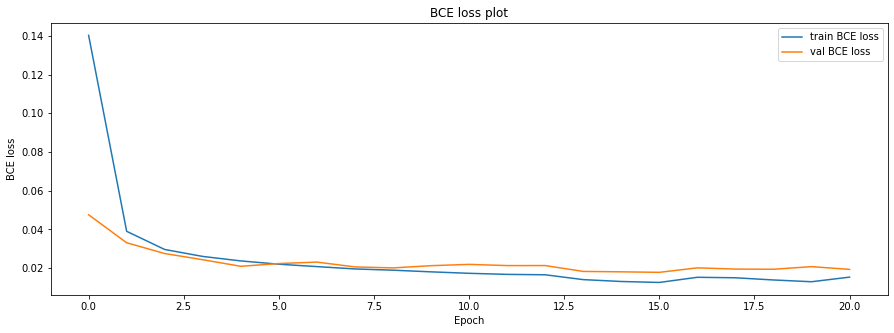

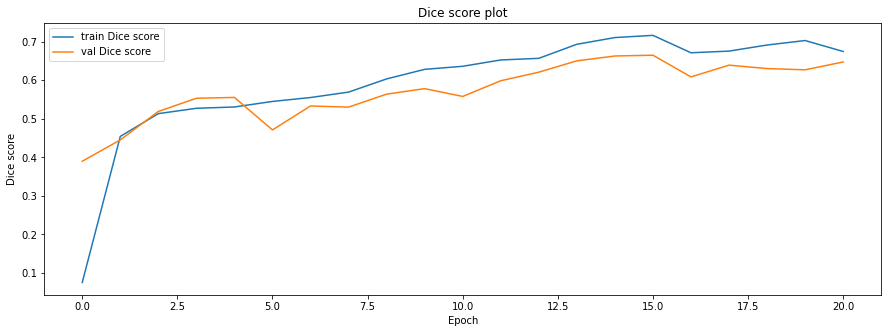

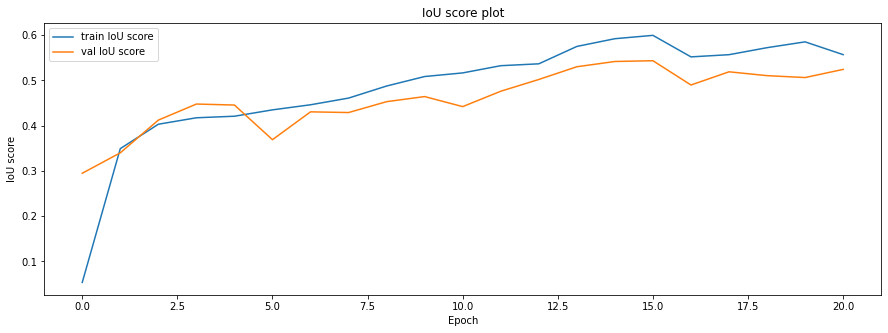

In [9]:
model_trainer = Trainer(model, state)
# PLOT TRAINING

losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):

    plt.figure(figsize=(15,5))

    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

### continue training with existing model

In [10]:
model_trainer = Trainer(model, state, batch_size = {"train": 4, "val": 4})
# model_trainer.start()


### Trainer Initialized with ###
Pretrained model: yes
Max Epochs: 20
Current Epoch: 17
Batch Size: {'train': 4, 'val': 4}
################################



In [11]:
val_data_set = model_trainer.dataloaders['val']

for img, mask in val_data_set:
    print(img.shape)
    
    print(mask.shape)
    for img_, mask_ in zip(img,mask):
        print(img_.shape)
        print(mask_.shape)

        for mask__ in mask_:
            print((mask__ == 0).all())
        break
    break

torch.Size([4, 3, 256, 1600])
torch.Size([4, 4, 256, 1600])
torch.Size([3, 256, 1600])
torch.Size([4, 256, 1600])
tensor(True)
tensor(True)
tensor(False)
tensor(True)


### evalaute model on images of validation set

In [12]:
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

In [13]:
std

(0.229, 0.224, 0.225)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class_ 0 and num 0
class_ 1 and num 0
class_ 2 and num 3
class_ 3 and num 0


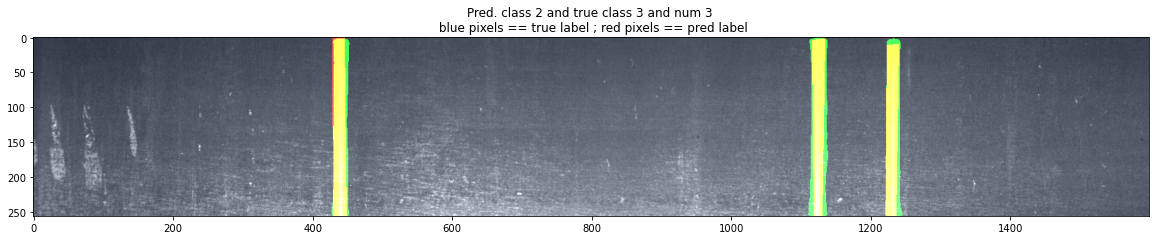

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class_ 0 and num 0
class_ 1 and num 0
class_ 2 and num 2
class_ 3 and num 2


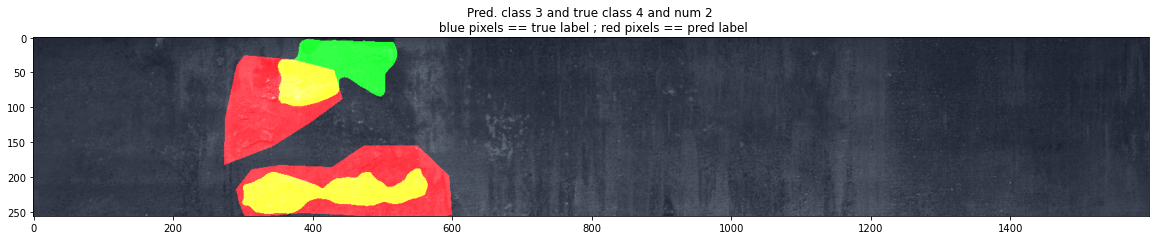

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class_ 0 and num 0
class_ 1 and num 0
class_ 2 and num 4
class_ 3 and num 0


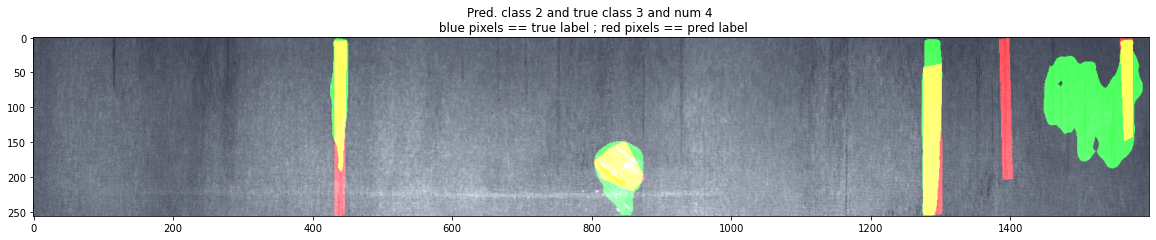

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class_ 0 and num 0
class_ 1 and num 0
class_ 2 and num 1
class_ 3 and num 0


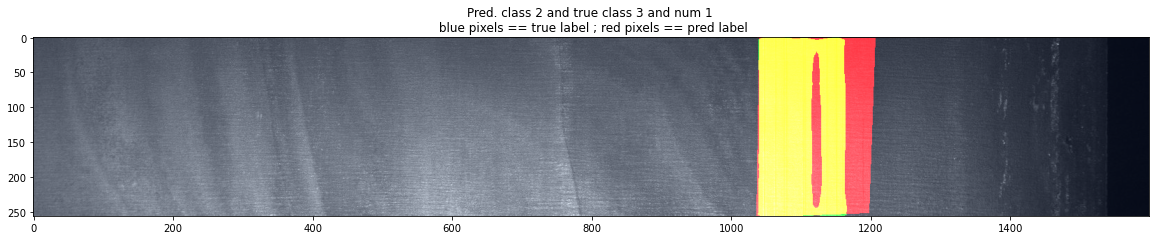

In [14]:
best_threshold = 0.5
min_size = 3500

val_data_set = model_trainer.dataloaders['val']


for iter0, (imgs_per_batch, masks_per_batch) in enumerate(val_data_set):

    for iter1, (img, masks) in enumerate(zip(imgs_per_batch, masks_per_batch)):

        # masks 4 x 400 x 1600 - one mask for each class
        for idx, mask in enumerate(masks):

            # if mask does not consist of only zeros, then this is the mask of the true label
            if not (mask == 0).all():
                
                true_mask = mask.numpy()
                true_class = idx + 1 # because we have classes 1, .. , 4 which are encoded by 0, .., 3 


        # take only first element of batch
        img = img.unsqueeze(0) # (1 x 3 x h x w)

        preds = torch.sigmoid(model(img.to(device)))
        preds = preds.detach().cpu().numpy()  # (1 x 4 x h x w)

        # print("batch_preds.shape", batch_preds.shape)

        img = inverse_normalize(tensor=img, 
                                mean=(0.485, 0.456, 0.406), 
                                std=(0.229, 0.224, 0.225))

        img = img[0].permute(1, 2, 0).numpy() # 

        preds = preds.squeeze(0)

        pred_mask = None
        pred_class = None
        pred_num = None 

        for class_, pred_per_class in enumerate(preds):
            # print(pred_per_class.shape,'pred_per_class.shape')
            

            pred, num = post_process(pred_per_class, best_threshold, min_size)

            # print(f'class {class_} with num {num}')
            print(f'class_ {class_} and num {num}')
            if num > 0: # not sure but I think num means number of connected segmentations

                pred_mask = pred
                pred_class = class_
                pred_num  = num

        # ,0 relates to the channel dimension
        img[true_mask==1,0] = 255 # we set the first channel dim to 255 for true mask
        img[pred_mask==1,1] = 255 # we set the third channel dim to 255 for pred mask
        
        fig=plt.figure(figsize=(20,100))

        plt.gca().set_title(f'Pred. class {pred_class} and true class {true_class} and num {pred_num} \n blue pixels == true label ; red pixels == pred label')
        plt.imshow(img)
        plt.show()

        if iter1 == 10:
            break

    if iter0 == 0:
        break


In [18]:
idx = 5

def get_pivot_table(df):
    
    df['ClassId'] = df['ClassId'].astype(int)
    
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    
    df['defects'] = df.count(axis=1)
    
    return df 

def get_prediction(idx):
    
    df_path = 'input/train.csv'

    df = pd.read_csv(df_path)
    
    df = get_pivot_table(df)

    image_id, mask = make_mask(idx, df)

    image_path = os.path.join('input', "train_images",  image_id)
    img = cv2.imread(image_path)

    list_trfms = Compose([ToTensor(), Normalize(mean=mean, std=std),])
    img = list_trfms(img)

    img = img.unsqueeze(0)


    preds = torch.sigmoid(model(img.to(device)))
    preds = preds.detach().cpu().numpy()  # (1 x 4 x h x w)

    preds = preds.squeeze(0)

    pred_mask = None
    pred_class = None
    pred_num = None 

    for class_, pred_per_class in enumerate(preds):

        pred, num = post_process(pred_per_class, best_threshold, min_size)

        print(f'class_ {class_} and num {num}')
        if num > 0: # not sure but I think num means number of connected segmentations
            pred_mask = pred
            pred_class = class_
            pred_num  = num

    preds = torch.sigmoid(model(img.to(device)))
    preds = preds.detach().cpu().numpy()  # (1 x 4 x h x w)

    masks = torch.tensor(mask).permute(2,0,1) # 4x256x1600

    img = img.squeeze(0)

    img = inverse_normalize(tensor=img, 
                            mean=(0.485, 0.456, 0.406), 
                            std=(0.229, 0.224, 0.225))

    img = img.permute(1, 2, 0).numpy() # 

    # masks 4 x 400 x 1600 - one mask for each class
    for mask_idx, mask in enumerate(masks):

        # if mask does not consist of only zeros, then this is the mask of the true label
        if not (mask == 0).all():

            true_mask = mask.numpy()
            true_class = mask_idx + 1 # because we have classes 1, .. , 4 which are encoded by 0, .., 3 
              

    img[true_mask==1,0] = 1 # we set the first channel dim to 255 for true mask
    img[pred_mask==1,1] = 1 # we set the third channel dim to 255 for pred mask
       
    fig=plt.figure(figsize=(20,100))
    plt.gca().set_title(f'Image ID {idx} with image name {image_id} \n Pred. class {pred_class} and true class {true_class} and num {pred_num} \n red pixels == true mask ; green pixels == pred mask ; yellow pixels == coincidence of predicted and true mask')
    plt.imshow(img)
    plt.show()    
    print(image_id)
    return img 

class_ 0 and num 0
class_ 1 and num 0
class_ 2 and num 1
class_ 3 and num 0


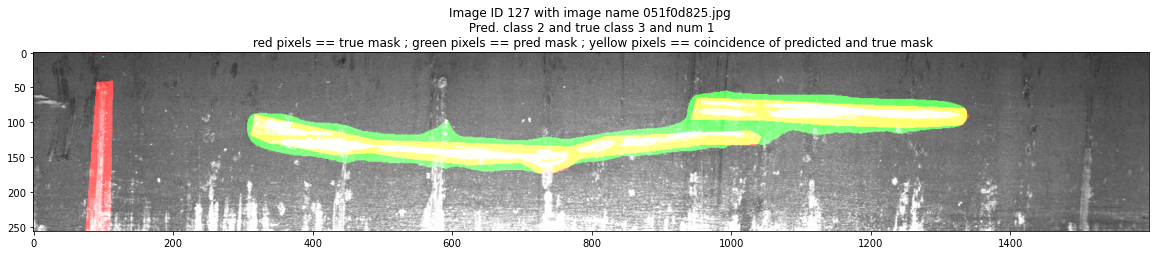

051f0d825.jpg


In [22]:
import random


randint = random.randrange(0,100)
img = get_prediction(127)
# img = get_prediction(93)



In [148]:
df_path = 'input/train.csv'

df = pd.read_csv(df_path)

df = get_pivot_table(df)
df.iloc[125:130].reset_index()

ClassId,ImageId,1,2,3,4,defects
0,05184e71b.jpg,NaN,NaN,110059 22 110273 64 110486 107 110700 149 1109...,NaN,1
1,0518e79e9.jpg,NaN,NaN,154369 38 154625 42 154881 46 155137 50 155393...,NaN,1
2,051f0d825.jpg,NaN,NaN,19450 7 19693 20 19935 34 20178 47 20421 60 20...,NaN,1
3,0526d780c.jpg,NaN,NaN,175873 6890 182785 192 183041 149 183297 107 1...,NaN,1
4,052838084.jpg,NaN,NaN,16439 1 16693 4 16947 7 17202 8 17456 11 17711...,NaN,1


In [16]:
torchvision.__version__

'0.9.0a0'